The goal here is to create a simple moving average model which gives us buy/sell/do_nothing signals in a list for each day depending on how the longer window moving average compares with the shorter window moving average. The moving average used in this model is the simple one, perhaps a more intersting model would be using the exponential moving average which puts more "weighting" on the more recent data. The choice of windows here from the SMAH and SMAL (Simple Moving Average High/Low) is fairly arbitrary, so experimentation with the windows on back data is another possible avenue I could go down to improve this simple model (and if there are any constraints I could place on the windows which work better in certain periods, is there a reason for this? i.e. does the choice of optimal windows correlate with some other external measurable quantity?). I'm using Bitcoin data which I downloaded from www.coindesk.com

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
BC_DATA = pd.read_csv('./datasets/BTC_USD_2013-10-01_2020-05-07-CoinDesk.csv')
BC_DATA['Date'] = pd.to_datetime(BC_DATA['Date'])

In [3]:
BC_DATA.set_index('Date')

,closing_price,open,high,low,asset
Date,,,,,
2013-01-10,123.654990,124.304660,124.751660,122.563490,BTC
2013-02-10,125.455000,123.654990,125.758500,123.633830,BTC
2013-03-10,108.584830,125.455000,125.665660,83.328330,BTC
2013-04-10,118.674660,108.584830,118.675000,107.058160,BTC
2013-05-10,121.338660,118.674660,121.936330,118.005660,BTC
...,...,...,...,...,...
2020-04-30,8767.672623,8768.047180,9469.078423,8415.474740,BTC
2020-01-05,8853.774484,8767.672143,9073.817530,8593.380363,BTC
2020-03-05,8904.713817,8850.788756,9223.385534,8747.433419,BTC


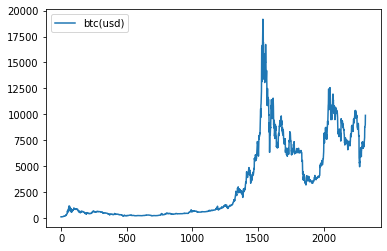

In [4]:
plt.plot(BC_DATA['closing_price'], label="btc(usd)")
plt.legend(loc='upper left');

In [5]:
SMAH = pd.DataFrame()
SMAL = pd.DataFrame()
SMAH['closing_price'] = BC_DATA['closing_price'].rolling(window=150).mean() 
SMAL['closing_price'] = BC_DATA['closing_price'].rolling(window=30).mean() 

#
#As mentioned above the choice of 150 and 30 as the windows is very arbitrary

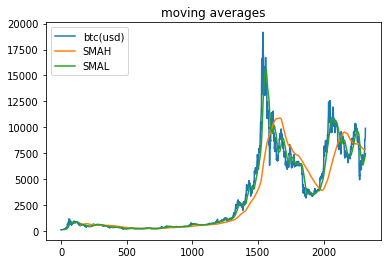

In [6]:
plt.plot(BC_DATA.index.values, BC_DATA['closing_price'], label="btc(usd)")
# plt.xticks(BC_DATA['closing_price'], BC_DATA.index.values)
plt.plot(SMAH['closing_price'], label='SMAH')
plt.plot(SMAL['closing_price'], label='SMAL')
plt.legend(loc='upper left')
plt.title('moving averages')
plt.show()

#As you can see the moving average curves follow the closing price curve (the lower window moving average curve
# following the cloing price more closely), but it the moving average curves has the effect of removing much of 
# the noise that is present in the closing price data.

Now we create a new DataFrame with all the relevant data we need to for our buy and sell indicator function.

In [7]:
data = pd.DataFrame()
data['BTC_DATA'] = BC_DATA['closing_price']
data['SMAL'] = SMAL['closing_price']
data['SMAH'] = SMAH['closing_price']
data['date'] = BC_DATA['Date']
data.set_index('date')

,BTC_DATA,SMAL,SMAH
date,,,
2013-01-10,123.654990,NaN,NaN
2013-02-10,125.455000,NaN,NaN
2013-03-10,108.584830,NaN,NaN
2013-04-10,118.674660,NaN,NaN
2013-05-10,121.338660,NaN,NaN
...,...,...,...
2020-04-30,8767.672623,7096.628550,7879.443690
2020-01-05,8853.774484,7168.995031,7889.200803
2020-03-05,8904.713817,7258.169214,7897.037123


In [8]:
data

,BTC_DATA,SMAL,SMAH,date
0,123.654990,NaN,NaN,2013-01-10
1,125.455000,NaN,NaN,2013-02-10
2,108.584830,NaN,NaN,2013-03-10
3,118.674660,NaN,NaN,2013-04-10
4,121.338660,NaN,NaN,2013-05-10
...,...,...,...,...
2315,8767.672623,7096.628550,7879.443690,2020-04-30
2316,8853.774484,7168.995031,7889.200803,2020-01-05
2317,8904.713817,7258.169214,7897.037123,2020-03-05
2318,8978.283587,7360.029006,7906.610776,2020-05-05


In [9]:
# Here we write the model itself.
def buy_sell(data):
    sig_price_buy = []
    sig_price_sell = []
    flag = -1 # important variable, e.g. prevents our for loop providing us with two buy signals on consecutive days.
    
    for i in range(len(data)):
        if data['SMAL'][i] > data['SMAH'][i]:
            if flag != 1:
                sig_price_buy.append(data['BTC_DATA'][i])
                sig_price_sell.append(np.nan)
                flag = 1
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        elif data['SMAL'][i] < data['SMAH'][i]:
            if flag != -1:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(data['BTC_DATA'][i])
                flag = -1
            else:
                sig_price_buy.append(np.nan)
                sig_price_sell.append(np.nan)
        else:
            sig_price_buy.append(np.nan)
            sig_price_sell.append(np.nan)
    return (sig_price_buy, sig_price_sell)

In [10]:
sig_prices = buy_sell(data)
data['buy'] = sig_prices[0]
data['sell'] = sig_prices[1]

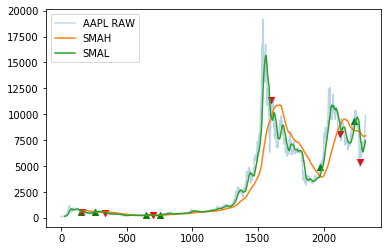

In [11]:
plt.scatter(data.index, data['buy'], marker='^', color='green')
plt.scatter(data.index, data['sell'], marker='v', color='red')
plt.plot(BC_DATA['closing_price'], label='AAPL RAW', alpha=0.3)
plt.plot(SMAH['closing_price'], label='SMAH')
plt.plot(SMAL['closing_price'], label='SMAL')
plt.legend(loc='upper left');

The green up arrows are buy signals and the red down arrows are the sell signals, none of those indicators seem like insane advice luckily, however seeing as those windows were arbitrary those signals clearly aren't optimal.